<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

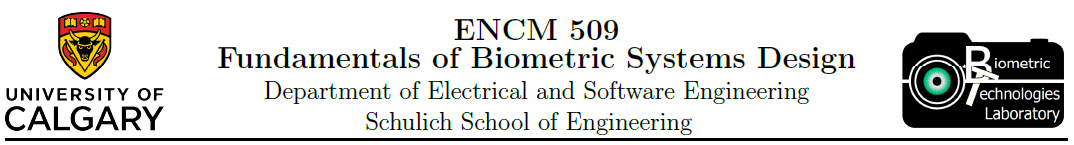

<center>
    <h1>Laboratory Experiment #6</h1>
    <h2>Face Recognition: Feature Extraction and Classification</h2>
</center>

#### Email: brian.kramer@ucalgary.ca 30069935, hoang.truong1@ucalgary.ca 30064426, jacob.lansang1@ucalgary.ca 30078981

## Introduction
The objective of this laboratory is to develop proficiency in face recognition techniques that involve a sequence of steps, including face detection within a frame, image processing to enhance the facial features, and extraction of features. We will delve into the conventional method of feature extraction for face recognition, which utilizes Principal Component Analysis (PCA), and threshold-based face matching, which relies on Euclidean Distance (ED). 

## Importing packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from utils_cm import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

- **Exercise 1** (3 marks): For this exercise, you are going to build a gallery and perform the classification (matching) for the three cases': face known to the gallery, face unknown to the gallery and not a face, as shown in Fig. 2 of the lab handout. However, you need to choose  two or three different subjects (for example, subjects 2, 3 and 4)  from the dataset (gallery), or create your own. Use the first 9 images of each subject to build the gallery. For example, if you choose 3 subjects, then you have a gallery of 3 x 9 = 27 faces, and for algorithm each  image is a sample, or input (no separate model is built per subject).

    Now, choose the probe images as follows: 
    1. The 10th image of each of the three  subjects  in the gallery.
    1. 2-3  faces of the subjects not known to the gallery.
    1. 1-2 not-a-face image. 

    For each of the  comparisons, save the Euclidean distances calculated, and mark the minimum and maximum value in each case.

In [2]:
# You can specify you directory here, please, change the string below:
path = './ATT dataset/s1/'

#### Number of images in your training set.

In [3]:
# M could be large (for example, 16: 8 of yours and 8 of a friend)
# for At&T dataset there are 10 faces per subject. 
# However, we are going to load only the first 9
# the 10th image will be used to compare later on.
M = 9

#### Image normalization:  

In [4]:
# can be any number that is close to the std and mean of most of the images.
um = 100
ustd = 80

Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304
Count: 10304
Size of each image: (112, 92) 10304


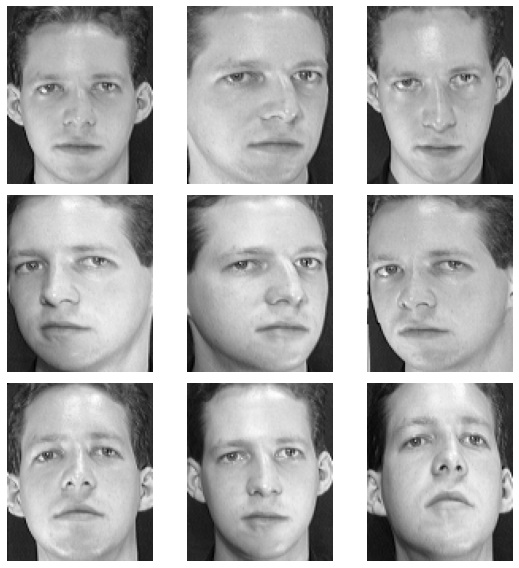

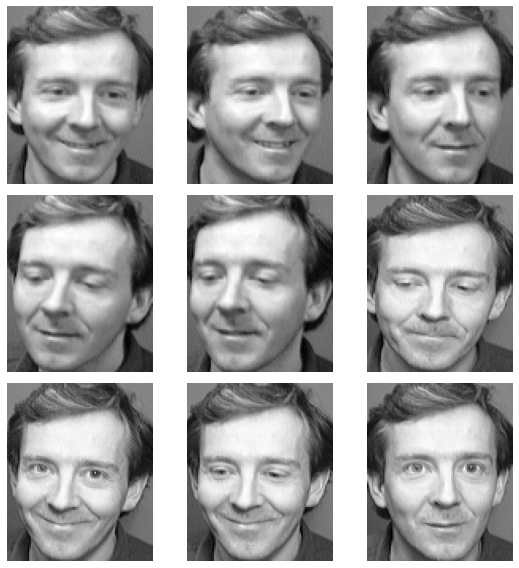

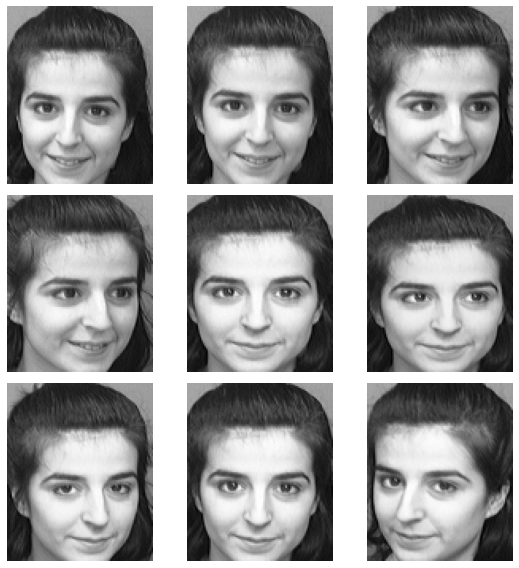

In [7]:
# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread('./ATT dataset/s1/' + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

# allocation of vector that will have all images
S = np.zeros((irow*icol, M)) # img matrix

plt.figure(figsize=(8,8))
for i in range(1,M+1):
    img = imread('./ATT dataset/s1/' + '{}.pgm'.format(i), as_gray=True)
    
    plt.subplot(3,3,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # reshape(img',irow*icol,1); 
    # creates a (N1*N2)x1 vector
    temp = np.reshape(img, (irow*icol,1))
    S[:,i-1] = temp[:,0] 
# after finishing the sequence, S is a N1*N2xM matrix 

print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]));
plt.figure(figsize=(8,8))

for i in range(1,M+1):
    img = imread('./ATT dataset/s3/' + '{}.pgm'.format(i), as_gray=True)
    
    plt.subplot(3,3,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # reshape(img',irow*icol,1); 
    # creates a (N1*N2)x1 vector
    temp = np.reshape(img, (irow*icol,1))
    S[:,i-1] = temp[:,0] 
# after finishing the sequence, S is a N1*N2xM matrix 

print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]));
plt.figure(figsize=(8,8))

for i in range(1,M+1):
    img = imread('./ATT dataset/s10/' + '{}.pgm'.format(i), as_gray=True)
    
    plt.subplot(3,3,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # reshape(img',irow*icol,1); 
    # creates a (N1*N2)x1 vector
    temp = np.reshape(img, (irow*icol,1))
    S[:,i-1] = temp[:,0] 
# after finishing the sequence, S is a N1*N2xM matrix 

count = len(S)
print("Count:", count)

print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]));

Here we **normalize** all images by changing the *mean* and *std* of each one. This is done to reduce the error due to lighting conditions and background.

In [ ]:
# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

### Normalized images

In [ ]:
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))

#### Mean image

In [ ]:
# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image');

#### Creating covariance matrix  L

In [ ]:
dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

#### Sort and eliminate zero eigenvalue

In [ ]:
v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

#### Normalization of eigenvectors

In [ ]:
for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

#### Showing eigenfaces

In [ ]:
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

#### Find the weight of each face in the training set

In [ ]:
omega = np.zeros((M,M))
WW = np.zeros((M,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

## Acquisition of new image: Same subject
*Notes*: 
- The input image must have a bmp, jpg or pgm extension. 
- It should have the same size as the ones in your training set. 

In [ ]:
# using the last image of subject #1
path = './ATT dataset/s1/'
InputImage = imread(path + '10.pgm', as_gray=True)

In [ ]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

#### Finding the Euclidean distance

In [ ]:
eSameSubject = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eSameSubject[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eSameSubject) 
MinimumValue = np.min(eSameSubject) 

In [ ]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eSameSubject)), eSameSubject.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

## Acquisition of new image: Other subject
*Notes*: 
- The input image must have a bmp, jpg or pgm extension. 
- It should have the same size as the ones in your training set. 

In [ ]:
# using the first face ('1.pgm') from subject 20
path = './ATT dataset/s20/'
InputImage = imread(path + '1.pgm', as_gray=True)

In [ ]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

### Finding the Euclidean distance

In [ ]:
eDiffSubject = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eDiffSubject[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eDiffSubject) 
MinimumValue = np.min(eDiffSubject) 

In [ ]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eDiffSubject)), eDiffSubject.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Other subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

## Acquisition of new image: Not Human Face
*Notes*: 
- The input image must have a bmp, jpg or pgm extension. 
- It should have the same size as the ones in your training set. 

In [ ]:
# using the first face ('1.pgm') from subject 20
path = './'
InputImage = imread(path + 'airpod.jpg', as_gray=True)

In [ ]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

### Finding the Euclidean distance

In [ ]:
eTower = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTower[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eTower) 
MinimumValue = np.min(eTower) 

In [ ]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eTower)), eTower.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not human face\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

#### Change and uncomment the fragment below using your Threshold values to classify the face as "Match", "non-Match", or "Not-a-face"

In [ ]:
# Set Threshold Values 
threshold1 = 14000
threshold2 = 15500

distances = eSameSubject
#distances = eDiffSubject
#distances = eTower


mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')

## Using PCA and KNN with Scikit-Learn

In [ ]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

In [ ]:
n_subjects = 20

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

### Descriptor: Principal Component Analysis (PCA)

In [ ]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [ ]:
print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))

### Initializing the PCA

In [ ]:
# n_components: number of principal components
n_components_pca = 100
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

#### Apply PCA to the two sets: Training and Test

In [ ]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

#### Mean image

In [ ]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

#### Eigenfaces

In [ ]:
fig = plt.figure(figsize=(16, 6))
for i in range(20):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

### Training the KNN

In [ ]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)

In [ ]:
predictedLabels = knn_pca.predict(test_pca)

### Evaluating the Results

In [ ]:
prediction_evaluation(predictedLabels, testingLabels)

In [ ]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

### Evaluating how many Principal Components are necessary

In [ ]:
lst_components = range(pca.n_components_)

pca_explained_var = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues
cum_sum_eigenvalues = np.cumsum(pca_explained_var)

In [ ]:
plt.figure(figsize=(16,6))
plt.bar(lst_components, pca_explained_var, label='Individual', color='green')
plt.step(lst_components, cum_sum_eigenvalues, where='mid', label='Cumulative')
plt.title('Explained Variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.legend()
plt.xlim([0, n_components_pca-1])
plt.ylim([0,1])
plt.xticks(lst_components)
plt.show()

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
1. Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section). (10 marks)
1. Conclusion (a paragraph on what is the main take-out of the lab).

- **Exercise 1** (3 marks): For this exercise, you are going to build a gallery and perform the classification (matching) for the three cases': face known to the gallery, face unknown to the gallery and not a face, as shown in Fig. 2 of the lab handout. However, you need to choose  two or three different subjects (for example, subjects 2, 3 and 4)  from the dataset (gallery), or create your own. Use the first 9 images of each subject to build the gallery. For example, if you choose 3 subjects, then you have a gallery of 3 x 9 = 27 faces, and for algorithm each  image is a sample, or input (no separate model is built per subject).

    Now, choose the probe images as follows: 
    1. The 10th image of each of the three  subjects  in the gallery.
    1. 2-3  faces of the subjects not known to the gallery.
    1. 1-2 not-a-face image. 

    For each of the  comparisons, save the Euclidean distances calculated, and mark the minimum and maximum value in each case.

- **Exercise 2** (3 marks): Determine the first and the second thresholds; hint: analyze the   maximum of the Euclidean distances  for the probe images known to the dataset. 
		
    To find the second threshold, use unknown faces as the input faces and gather all the  Euclidean distance. Hint: consider the maximum as the second threshold, but also analyze other values.

- **Exercise 3** (2 marks): In the description of the face recognition using PCA and KNN above, the PCA was used with 100 principal components. Now repeat the same procedure using 50 and 200 principal components. Evaluate the resulting classifier  accuracy, using Confusion matrix. Visualize the comparison using either a table or a bar plot (comparing the results for the three number of components: 50, 100 (already done) and 200). 

- **Exercise 4** (2 marks): Evaluate the impact of the number of neighbors $(K)$ defined for the KNN. Using the same data separation  (20 subjects, 8 images per subject are used for training and 2 for testing), conduct the two  experiments considering, for example: 1) 5 neighbors and, 2) 11 neighbors.  Compare the KNN classifier results, using Confusion matrices, and draw the conclusions.